We certify that the code and data in this assignment were generated independently, using only the tools and resources defined in the course and that I/we did not receive any external help, coaching or contributions during the production of this work.

# Assignment 2 - Team 16
---

### 3.1 Improving vanila version of DQN

We apply Double DQN to improve vanilla version of our DQN algorithms.

In [1]:
import gym
import gym.spaces as spaces
import numpy as np
from random import sample
import torch
import torch.nn as nn

Two things has been changed from the Assignment 1 (Sungjoon Park).
- rewards
    - {0, -0.2, 0.3, -0.7, 1} &rarr; {0, 0.2, 0.3, 0.7, 1}
- time limit
    - 15 &rarr; 20

In [2]:
class GridEnvironment_Deterministic(gym.Env):
    metadata = { 'render.modes': [] }
    
    def __init__(self):
        self.observation_space = spaces.Discrete(16)
        self.action_space = spaces.Discrete(4)
        self.max_timesteps = 20
        
    def reset(self):
        self.timestep = 0
        self.agent_pos = [0, 0]
        self.pos_1 = [0, 3]
        self.pos_2 = [3, 0]
        self.pos_3 = [1, 2]
        self.goal_pos = [3, 3]
        self.state = np.zeros((4, 4))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.pos_1)] = 0.2
        self.state[tuple(self.pos_2)] = 0.2
        self.state[tuple(self.pos_3)] = 0.5
        self.state[tuple(self.goal_pos)] = 0.7
        observation = self.state.flatten()
        return observation
    
    def step(self, action):
        p = np.random.random()
        if action == 0: # down
            self.agent_pos[0] += 1
        if action == 1: # up
            self.agent_pos[0] -= 1
        if action == 2: # right
            self.agent_pos[1] += 1
        if action == 3: # left
            self.agent_pos[1] -= 1

        self.agent_pos = np.clip(self.agent_pos, 0, 3)
        self.state = np.zeros((4, 4))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.pos_1)] = 0.2
        self.state[tuple(self.pos_2)] = 0.2
        self.state[tuple(self.pos_3)] = 0.5
        self.state[tuple(self.goal_pos)] = 0.7
        observation = self.state.flatten()
        
        reward = 0
        if (self.agent_pos == self.pos_1).all():
            reward = -0.7
        if (self.agent_pos == self.pos_2).all():
            reward = -0.3
        if (self.agent_pos == self.pos_3).all():
            reward = 0.2
        if (self.agent_pos == self.goal_pos).all():
            reward = 5.0
        
        self.timestep += 1
        if self.timestep >= self.max_timesteps:
            done = True
        else:
            if (self.agent_pos == self.goal_pos).all():
                done = True
            else:
                done = False
        info = {}
                
        return observation, reward, done, info
        
    def render(self):
        #plt.imshow(self.state)
        v_pi = self.state
        fig, ax = plt.subplots(1, 1, figsize = (12, 6))
        visualize_value_function(ax, v_pi, nx, ny)
        _ = ax.set_title("Value pi")

Deep Q-network (using the codes in the checkpoint)

In [3]:
class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = [None] * max_size
        self.max_size = max_size
        self.index = 0
        self.size = 0
        
    def push(self, experience):
        self.buffer[self.index] = experience
        self.size = min(self.size + 1, self.max_size)
        self.index = (self.index + 1) % self.max_size
        
    def sample(self, batch_size):
        indices = sample(range(self.size), batch_size)
        return [self.buffer[index] for index in indices]
        
    def __len__(self):
        return self.size

In [4]:
def to_device_cpu(sample, device = 'cpu'):
    states = []
    actions = []
    rewards = []
    next_states = []
    dones = []
    
    for i in sample:
        states.append(i[0])
        actions.append(i[1])
        rewards.append(i[2])
        next_states.append(i[3])
        dones.append(i[4])
    
    states = torch.cat(states, dim = 0).float().to(device)
    actions = torch.cat(actions, dim = 0).to(device)
    rewards = torch.cat(rewards, dim = 0).float().to(device)
    next_states = torch.cat(next_states, dim = 0).float().to(device)
    dones = torch.cat(dones, dim = 0).float().to(device)
    
    return states, actions, rewards, next_states, dones

In [5]:
class DQN(nn.Module):
    def __init__(self,
                 state_space: int,
                 action_space: int,
                 q_network: nn.Module,
                 target_network: nn.Module,
                 lr: float,
                 gamma: float,
                 eps: float):
        """
        state_space: input state dimension
        action_space: input action dimension
        q_network: main Q-network
        target_network: Target Q-network
        lr: learning rate
        gamma: discount factor
        eps: epsilon-greedy factor
        """
        
        super(DQN, self).__init__()
        self.state_space = state_space
        self.action_space = action_space
        self.q_network = q_network
        self.lr = lr
        self.gamma = gamma
        self.eps = eps
        self.optimizer = torch.optim.Adam(
            params = self.q_network.parameters(), lr = lr)
        self.register_buffer('epsilon', torch.ones(1) * eps)
        self.target_network = target_network
        self.criteria = nn.MSELoss()
        
    def get_action(self, state):
        prob = np.random.uniform(0.0, 1.0, 1)
        if torch.from_numpy(prob).float() <= self.eps:
            return int(np.random.choice(range(self.action_space)))
        else:
            return int(self.q_network(state).argmax(dim = -1))
    
    def update(self, state, action, reward, next_state, done):
        with torch.no_grad():
            max_q, _ = self.target_network(next_state).max(dim = -1, keepdims = True)
            q_target = reward + self.gamma * max_q * (1 - done)
        q_val = self.q_network(state).gather(1, action)
        loss = self.criteria(q_val, q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [6]:
class QLearner(nn.Module):
    def __init__(self,
                 input_dim: int,
                 output_dim: int,
                 num_neurons: list = [128, 64, 32],
                 hidden_activation: str = 'ReLU',
                 out_activation: str = 'Identity'):
        super(QLearner, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_neurons = num_neurons
        self.hidden_activation = getattr(nn, hidden_activation)()
        self.out_activation = getattr(nn, out_activation)()
        
        input_dims = [input_dim] + num_neurons
        output_dims = num_neurons + [output_dim]

        self.layers = nn.ModuleList()
        for i, (in_dim, out_dim) in enumerate(zip(input_dims, output_dims)):
            is_last = True if i == len(input_dims) - 1 else False
            self.layers.append(nn.Linear(in_dim, out_dim))
            if is_last:
                self.layers.append(self.out_activation)
            else:
                self.layers.append(self.hidden_activation)
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [7]:
state_space = 16
action_space = 4

input_dim = 1
num_neurons = [128, 64, 32]
q_network = QLearner(input_dim = input_dim,
                     output_dim = action_space,
                     num_neurons = num_neurons)
target_network = QLearner(input_dim = input_dim,
                          output_dim = action_space,
                          num_neurons = num_neurons)

In [8]:
num_episodes = 3000

lr = 0.002
gamma = 0.99
eps = 1.0
eps_decaying = (0.01 / eps)**(1 / num_episodes )
interval = 10
memory_size = 50000
batch_size = 256

In [9]:
dqn = DQN(state_space,
          action_space,
          q_network = q_network,
          target_network = target_network,
          lr = lr,
          gamma = gamma,
          eps = eps)
env = GridEnvironment_Deterministic()
memory = ReplayBuffer(memory_size)

In [10]:
def to_tensor(np_array: np.array, size = None) -> torch.tensor:
    torch_tensor = torch.from_numpy(np_array).float()
    if size is not None:
        torch_tensor = torch_tensor.view(size)
    return torch_tensor

In [11]:
total_rewards = []
epsilon = []
print_every = 500

for ep in range(num_episodes):

    dqn.eps = torch.tensor(eps)
    env.reset()
    total_reward = 0
    state = env.agent_pos[0] * 4 + env.agent_pos[1]
    while True:
        
        action = dqn.get_action(torch.tensor(float(state)).view(1, 1))
        _, reward, done, _ = env.step(action)
        next_state = env.agent_pos[0] * 4 + env.agent_pos[1]

        experience = (torch.tensor(state).view(1, 1),
                      torch.tensor(action).view(1, 1),
                      torch.tensor(reward).view(1, 1),
                      torch.tensor(next_state).view(1, 1),
                      torch.tensor(done).view(1, 1))
        memory.push(experience)

        state = next_state
        total_reward *= gamma
        total_reward += reward

        if done:
            break

    total_rewards.append(total_reward)
    epsilon.append(eps)

    eps = eps * eps_decaying
    
    if len(memory) >= 2000:
        sampled = memory.sample(batch_size)
        sampled = to_device_cpu(sampled)
        dqn.update(*sampled)

    if ep % interval == 0:
        target_network.load_state_dict(q_network.state_dict())
    
    if ep % print_every == (print_every - 1):
        print(f"Episode: {ep + 1:4.0f}\t| "
              + f"Total Reward: {total_reward:3.2f}\t| "
              + f"Epsilon: {eps:.3f}")

Episode:  500	| Total Reward: 4.14	| Epsilon: 0.464
Episode: 1000	| Total Reward: 4.71	| Epsilon: 0.215
Episode: 1500	| Total Reward: 5.19	| Epsilon: 0.100
Episode: 2000	| Total Reward: -4.68	| Epsilon: 0.046
Episode: 2500	| Total Reward: 4.71	| Epsilon: 0.022
Episode: 3000	| Total Reward: -4.96	| Epsilon: 0.010


In [12]:
import matplotlib.pyplot as plt

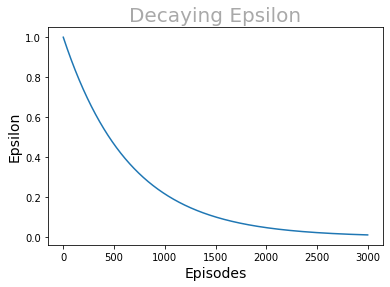

In [13]:
# the plot for epsilons
fig, ax = plt.subplots()
ax.plot(epsilon)
ax.set_xlabel("Episodes", fontsize = 14)
ax.set_ylabel("Epsilon", color = "black", fontsize = 14)
plt.title('Decaying Epsilon', color = "darkgrey", fontsize = 20)
plt.show()

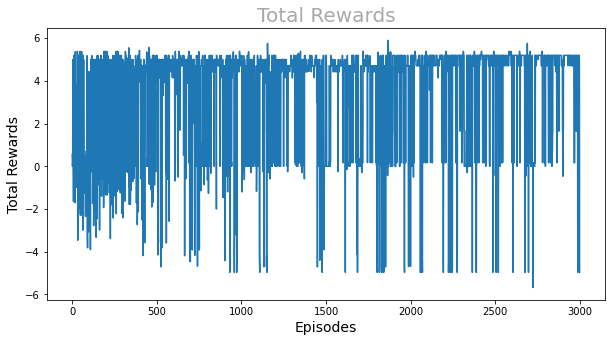

In [14]:
# the plot for rewards
fig, ax = plt.subplots(figsize = (10, 5))
ax.plot(total_rewards)
ax.set_xlabel("Episodes", fontsize = 14)
ax.set_ylabel("Total Rewards", color = "black", fontsize = 14)
plt.title('Total Rewards', color = "darkgrey", fontsize = 20)
plt.show()

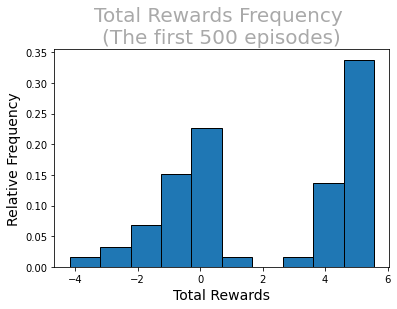

In [15]:
# Plot a relative frequency for episodes 0 ~ 2000
fig = plt.figure(figsize = (6, 4))
ax = fig.add_subplot(111)
ax.hist(total_rewards[:500], edgecolor = 'black',
        weights = np.ones_like(total_rewards[:500]) / len(total_rewards[:500]))
ax.set_xlabel("Total Rewards", fontsize = 14)
ax.set_ylabel("Relative Frequency", color = "black", fontsize = 14)
plt.title('Total Rewards Frequency \n(The first 500 episodes)', color = "darkgrey", fontsize = 20)
plt.show()

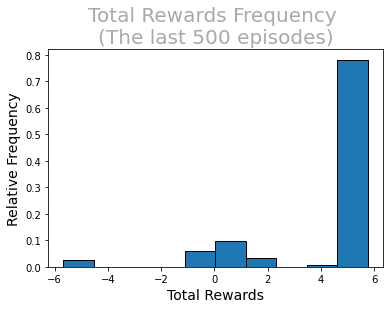

In [16]:
# Plot a relative frequency for the last 1000 episodes
fig = plt.figure(figsize = (6, 4))
ax = fig.add_subplot(111)
ax.hist(total_rewards[-500:], edgecolor = 'black',
        weights = np.ones_like(total_rewards[-500:]) / len(total_rewards[-500:]))
ax.set_xlabel("Total Rewards", fontsize = 14)
ax.set_ylabel("Relative Frequency", color = "black", fontsize = 14)
plt.title('Total Rewards Frequency \n(The last 500 episodes)', color = "darkgrey", fontsize = 20)
plt.show()

Only greedy actions from the learnt policy (DQN)

In [17]:
total_rewards_greedy = []
print_every = 1

num_episodes = 5

for ep in range(num_episodes):
    env.reset()
    dqn.eps = torch.tensor(0.0)
    total_reward = 0
    state = env.agent_pos[0] * 4 + env.agent_pos[1]
    # for an episode..
    while True:
              
        # The agent chooses actions only in terms of greedy policy.
        action = dqn.get_action(torch.tensor(float(state)).view(1, 1))
        _, reward, done, _ = env.step(action)
        next_state = env.agent_pos[0] * 4 + env.agent_pos[1]

        state = next_state
        total_reward *= gamma
        total_reward += reward

        if done: # Terminate the loop once an episode ends.
            break

    total_rewards_greedy.append(total_reward)

    if ep % 1 == (print_every - 1):
        print(f"Episode: {ep + 1:4.0f} | "
              + f"Total Reward: {total_reward:3.2f}")

Episode:    1 | Total Reward: 4.71
Episode:    2 | Total Reward: 4.71
Episode:    3 | Total Reward: 4.71
Episode:    4 | Total Reward: 4.71
Episode:    5 | Total Reward: 4.71


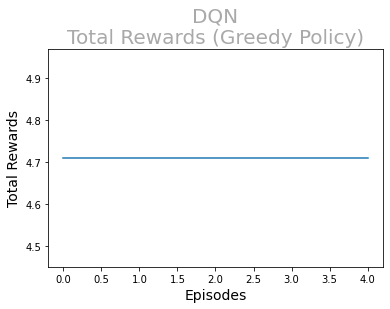

In [18]:
# the plot for total rewards of the greedy policy
fig, ax = plt.subplots()
ax.plot(total_rewards_greedy)
ax.set_xlabel("Episodes", fontsize = 14)
ax.set_ylabel("Total Rewards", color = "black", fontsize = 14)
plt.title('DQN\nTotal Rewards (Greedy Policy)', color = "darkgrey", fontsize = 20)
plt.show()

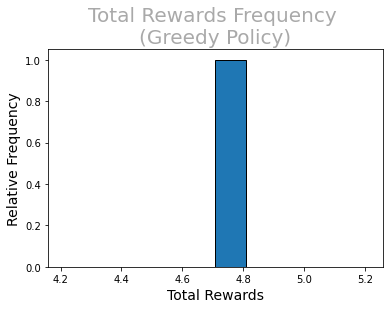

In [19]:
# Plot a relative frequency since the plot is just above hardly interpretable..
fig = plt.figure(figsize = (6, 4))
ax = fig.add_subplot(111)
ax.hist(total_rewards_greedy, edgecolor = 'black',
        weights = np.ones_like(total_rewards_greedy) / len(total_rewards_greedy))
ax.set_xlabel("Total Rewards", fontsize = 14)
ax.set_ylabel("Relative Frequency", color = "black", fontsize = 14)
plt.title('Total Rewards Frequency \n(Greedy Policy)', color = "darkgrey", fontsize = 20)
plt.show()

Implementing Double DQN

In [20]:
class DoubleDQN(nn.Module):
    def __init__(self,
                 state_space: int,
                 action_space: int,
                 q_network: nn.Module,
                 target_network: nn.Module,
                 lr: float,
                 gamma: float,
                 eps: float):
        """
        state_space: input state dimension
        action_space: input action dimension
        q_network: main Q-network
        target_network: Target Q-network
        lr: learning rate
        gamma: discount factor
        eps: epsilon-greedy factor
        """
        
        super(DoubleDQN, self).__init__()
        self.state_space = state_space
        self.action_space = action_space
        self.q_network = q_network
        self.lr = lr
        self.gamma = gamma
        self.eps = eps
        self.optimizer = torch.optim.Adam(
            params = self.q_network.parameters(), lr = lr)
        self.register_buffer('epsilon', torch.ones(1) * eps)
        self.target_network = target_network
        self.criteria = nn.MSELoss()
        
    def get_action(self, state):
        prob = np.random.uniform(0.0, 1.0, 1)
        if torch.from_numpy(prob).float() <= self.eps:
            return int(np.random.choice(range(self.action_space)))
        else:
            return int(self.q_network(state).argmax(dim = -1))
    
    def update(self, state, action, reward, next_state, done):
        with torch.no_grad():
            greedy_action = self.q_network(next_state).argmax(dim = -1)
            greedy_action = greedy_action[:, None]
            doubledqn_q_max = self.target_network(next_state).gather(1, greedy_action)
            q_target = reward + self.gamma * doubledqn_q_max * (1 - done)
        q_val = self.q_network(state).gather(1, action)
        loss = self.criteria(q_val, q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [21]:
q_network_double = QLearner(input_dim = input_dim,
                            output_dim = action_space,
                            num_neurons = num_neurons)
target_network_double = QLearner(input_dim = input_dim,
                                 output_dim = action_space,
                                 num_neurons = num_neurons)

In [22]:
eps = 1.0
doubledqn = DoubleDQN(state_space,
                      action_space,
                      q_network = q_network_double,
                      target_network = target_network_double,
                      lr = lr,
                      gamma = gamma,
                      eps = eps)
env = GridEnvironment_Deterministic()
memory = ReplayBuffer(memory_size)

In [23]:
total_rewards_double = []
epsilon_double = []
num_episodes = 3000
print_every = 500

for ep in range(num_episodes):

    doubledqn.eps = torch.tensor(eps)
    env.reset()
    total_reward_double = 0
    state = env.agent_pos[0] * 4 + env.agent_pos[1]
    
    while True:
        
        action = doubledqn.get_action(torch.tensor(float(state)).view(1, 1))
        _, reward, done, _ = env.step(action)
        next_state = env.agent_pos[0] * 4 + env.agent_pos[1]

        experience = (torch.tensor(state).view(1, 1),
                      torch.tensor(action).view(1, 1),
                      torch.tensor(reward).view(1, 1),
                      torch.tensor(next_state).view(1, 1),
                      torch.tensor(done).view(1, 1))
        memory.push(experience)

        state = next_state
        total_reward_double *= gamma
        total_reward_double += reward

        if done:
            break

    total_rewards_double.append(total_reward_double)
    epsilon_double.append(eps)

    eps = eps * eps_decaying
    
    if len(memory) >= 2000:
        sampled = memory.sample(batch_size)
        sampled = to_device_cpu(sampled)
        doubledqn.update(*sampled)

    if ep % interval == 0:
        target_network_double.load_state_dict(q_network_double.state_dict())
    
    if ep % print_every == (print_every - 1):
        print(f"Episode: {ep + 1:4.0f}\t| "
              + f"Total Reward: {total_reward_double:3.2f}\t| "
              + f"Epsilon: {eps:.3f}")

Episode:  500	| Total Reward: 4.71	| Epsilon: 0.464
Episode: 1000	| Total Reward: 5.00	| Epsilon: 0.215
Episode: 1500	| Total Reward: 5.00	| Epsilon: 0.100
Episode: 2000	| Total Reward: 5.00	| Epsilon: 0.046
Episode: 2500	| Total Reward: 4.71	| Epsilon: 0.022
Episode: 3000	| Total Reward: 5.19	| Epsilon: 0.010


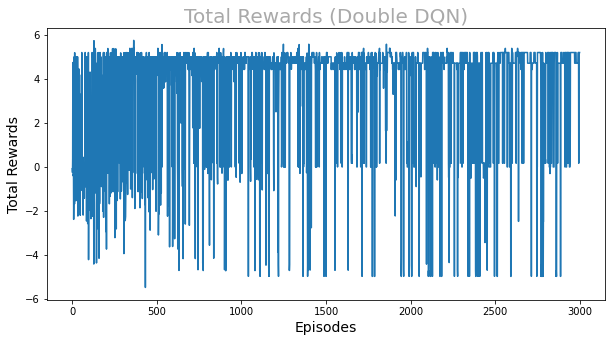

In [24]:
# the plot for rewards
fig, ax = plt.subplots(figsize = (10, 5))
ax.plot(total_rewards_double)
ax.set_xlabel("Episodes", fontsize = 14)
ax.set_ylabel("Total Rewards", color = "black", fontsize = 14)
plt.title('Total Rewards (Double DQN)', color = "darkgrey", fontsize = 20)
plt.show()

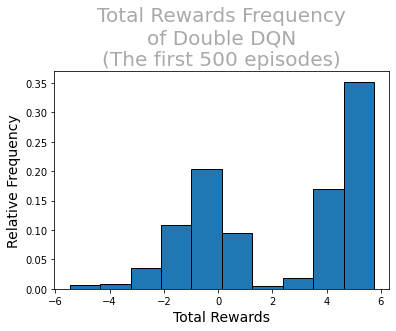

In [25]:
# Plot a relative frequency for episodes 0 ~ 2000
fig = plt.figure(figsize = (6, 4))
ax = fig.add_subplot(111)
ax.hist(total_rewards_double[:500], edgecolor = 'black',
        weights = np.ones_like(total_rewards_double[:500]) /
        len(total_rewards_double[:500]))
ax.set_xlabel("Total Rewards", fontsize = 14)
ax.set_ylabel("Relative Frequency", color = "black", fontsize = 14)
plt.title('Total Rewards Frequency\nof Double DQN\n(The first 500 episodes)', color = "darkgrey", fontsize = 20)
plt.show()

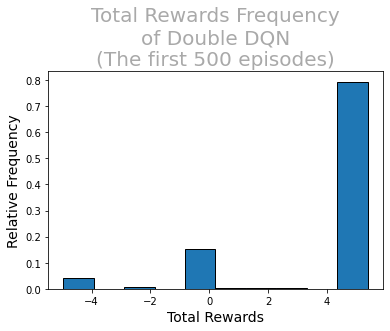

In [26]:
# Plot a relative frequency for episodes 0 ~ 2000
fig = plt.figure(figsize = (6, 4))
ax = fig.add_subplot(111)
ax.hist(total_rewards_double[-500:], edgecolor = 'black',
        weights = np.ones_like(total_rewards_double[-500:]) /
        len(total_rewards_double[-500:]))
ax.set_xlabel("Total Rewards", fontsize = 14)
ax.set_ylabel("Relative Frequency", color = "black", fontsize = 14)
plt.title('Total Rewards Frequency\nof Double DQN\n(The first 500 episodes)', color = "darkgrey", fontsize = 20)
plt.show()

Only greedy actions from the learnt policy (Double DQN)

In [27]:
total_rewards_double_greedy = []
print_every = 1

num_episodes = 5

for ep in range(num_episodes):
    env.reset()
    total_reward_double = 0
    state = env.agent_pos[0] * 4 + env.agent_pos[1]

    while True:
              
        # The agent chooses actions only in terms of greedy policy.
        action = doubledqn.get_action(torch.tensor(float(state)).view(1, 1))
        _, reward, done, _ = env.step(action)
        next_state = env.agent_pos[0] * 4 + env.agent_pos[1]

        state = next_state
        total_reward_double *= gamma
        total_reward_double += reward

        if done:
            break

    total_rewards_double_greedy.append(total_reward_double)

    if ep % 1 == (print_every - 1):
        print(f"Episode: {ep + 1:4.0f} | "
              + f"Total Reward: {total_reward_double:3.2f}")

Episode:    1 | Total Reward: 5.19
Episode:    2 | Total Reward: 5.19
Episode:    3 | Total Reward: 5.19
Episode:    4 | Total Reward: 5.19
Episode:    5 | Total Reward: 5.19


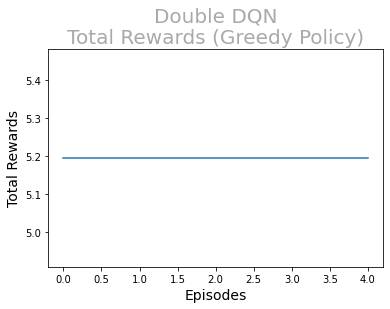

In [38]:
# the plot for total rewards of the greedy policy
fig, ax = plt.subplots()
ax.plot(total_rewards_double_greedy)
ax.set_xlabel("Episodes", fontsize = 14)
ax.set_ylabel("Total Rewards", color = "black", fontsize = 14)
plt.title('Double DQN\nTotal Rewards (Greedy Policy)', color = "darkgrey", fontsize = 20)
plt.show()

In [31]:
eps_test = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
total_rewards_eps = []

num_episodes = 1000

for eps in eps_test:
    avg_reward = 0
    count = 0

    for ep in range(num_episodes):
        env.reset()
        count += 1
        dqn.eps = eps
        total_reward = 0
        state = env.agent_pos[0] * 4 + env.agent_pos[1]

        while True:

            action = dqn.get_action(torch.tensor(float(state)).view(1, 1))
            _, reward, done, _ = env.step(action)
            next_state = env.agent_pos[0] * 4 + env.agent_pos[1]

            state = next_state
            total_reward *= gamma
            total_reward += reward

            if done:
                break
        avg_reward += (total_reward - avg_reward) / count

    total_rewards_eps.append(avg_reward)

In [32]:
total_rewards_double_eps = []

num_episodes = 1000

for eps in eps_test:
    avg_reward_double = 0
    count = 0

    for ep in range(num_episodes):
        env.reset()
        count += 1
        doubledqn.eps = eps
        total_reward_double = 0
        state = env.agent_pos[0] * 4 + env.agent_pos[1]

        while True:

            action = doubledqn.get_action(torch.tensor(float(state)).view(1, 1))
            _, reward, done, _ = env.step(action)
            next_state = env.agent_pos[0] * 4 + env.agent_pos[1]

            state = next_state
            total_reward_double *= gamma
            total_reward_double += reward

            if done:
                break
        avg_reward_double += (total_reward_double - avg_reward_double) / count

    total_rewards_double_eps.append(avg_reward_double)

In [ ]:
import pandas as pd

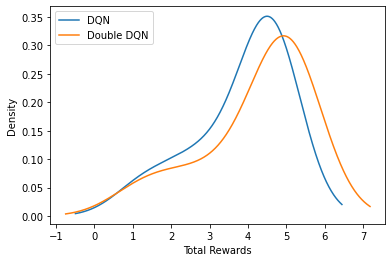

In [33]:
fig, ax = plt.subplots(1, 1)
_ = pd.Series(total_rewards_eps, name = "total_rewards").plot(kind = "kde", ax = ax, label = "DQN")
_ = pd.Series(total_rewards_double_eps, name = "total_rewards_double").plot(kind = "kde", ax = ax, label = "Double DQN")
_ = ax.set_xlabel("Total Rewards")
_ = ax.legend()

In [34]:
(max(eps_test) / (len(eps_test) - 1))

0.1

In [35]:
np.arange(
    0, max(eps_test) + (max(eps_test) / (len(eps_test) - 1)),
    (max(eps_test) / (len(eps_test) - 1))).round(1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

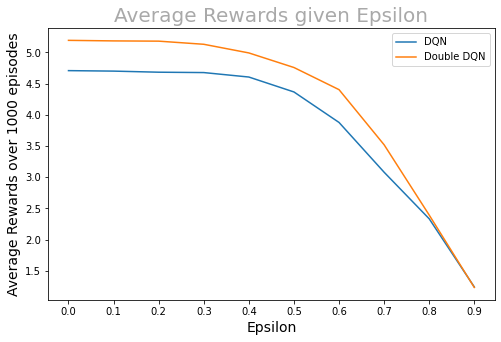

In [36]:
# the plot for rewards
fig, ax = plt.subplots(figsize = (8, 5))
ax.plot(total_rewards_eps)
ax.plot(total_rewards_double_eps)
ax.set_xlabel("Epsilon", fontsize = 14)
ax.set_ylabel("Average Rewards over 1000 episodes", color = "black", fontsize = 14)
plt.xticks(np.arange(0, len(eps_test), 1), np.arange(
    0, max(eps_test) + (max(eps_test) / (len(eps_test) - 1)),
    (max(eps_test) / (len(eps_test) - 1))).round(1))
plt.title('Average Rewards given Epsilon', color = "darkgrey", fontsize = 20)
plt.legend(['DQN', 'Double DQN'])
plt.show()